In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Traitement des images


from os import listdir

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Bag of word

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Recupération des données

data = pd.read_csv('/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
# On récupère les première catégories dans la colonne product category tree

data['product_category_tree_preprocess'] = data['product_category_tree'].apply(lambda x : x[2:-2].split(' >> '))

# On teste les labels avec la categorie du produit

data['label_name'] = data['product_category_tree_preprocess'].apply(lambda x : x[0])



In [5]:
# On combine la description et le titre pour maximiser les informations

data['to_embed'] = data['product_name'] + ' '+ data['description']

In [6]:
# Tokenizer : Remplace la phrase par une liste de mots

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words : Mots du type the, is, a ... Inutile pour la comprehension d'une phrase
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

# Retire les stopwords et les mots de 2 lettre ou moins
def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha : Met tout les mots en minuscule (sauf les mots commencant par @ et http)
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot) : Remplace un mot par sa racine 
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [7]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [8]:
# On prepare l'embeding. On choisit sur quel colonne on va le faire

#to_embed = 'description'
to_embed = 'product_name'

data['sentence_bow'] = data[to_embed].apply(lambda x : transform_bow_fct(x))
data['sentence_bow_lem'] = data[to_embed].apply(lambda x : transform_bow_lem_fct(x))
data['sentence_dl'] = data[to_embed].apply(lambda x : transform_dl_fct(x))
data.shape

(1050, 21)

In [9]:
l_cat = list(set(data['label_name']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data.iloc[i]['label_name'])) for i in range(len(data))]

catégories :  ['Baby Care', 'Home Furnishing', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Computers', 'Watches', 'Kitchen & Dining']


In [10]:
data['length_bow'] = data['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data['length_bow'].max())
data['length_dl'] = data['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data['length_dl'].max())

max length bow :  24
max length dl :  30


# Préparation commune des traitements

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

In [12]:
# On va extraire les features textes avec USE car ce modèle nous donne le meilleur score ARI

# USE - Universal Sentence Encoder

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
#from transformers import *
import os

os.environ["TF_KERAS"]='1'

In [15]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.2
2.9.2
Num GPUs Available:  0
True


In [16]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [17]:
# Embed les phrases avec USE
# Info sur USE
# https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [18]:
batch_size = 10
sentences = data['sentence_dl'].to_list()

In [19]:
features_USE = feature_USE_fct(sentences, batch_size)

## Extraction des features images avec CNN

In [20]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.model_selection import train_test_split

# Label encoder

from sklearn import preprocessing

from tensorflow.keras.utils import to_categorical

# Affichage des images

from PIL import Image

from matplotlib.image import imread

import cv2

# Traitement des images

import os
from os import listdir

In [21]:
# On preprocess les labels

le = preprocessing.LabelEncoder()

data["label"] = le.fit_transform(data["label_name"])

In [22]:
# On crée un path vers les images

data['image_path'] = "/Flipkart/Images/" + data['image']

In [23]:
data[["image_path","label_name","label"]].head()

,image_path,label_name,label
0,/Flipkart/Images/55b85ea15a1536d46b7190ad6fff8...,Home Furnishing,4
1,/Flipkart/Images/7b72c92c2f6c40268628ec5f14c6d...,Baby Care,0
2,/Flipkart/Images/64d5d4a258243731dc7bbb1eef49a...,Baby Care,0
3,/Flipkart/Images/d4684dcdc759dd9cdf41504698d73...,Home Furnishing,4
4,/Flipkart/Images/6325b6870c54cd47be6ebfbffa620...,Home Furnishing,4


## VGG16

In [24]:
# loading the vgg16 model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump

In [25]:
# On utilise le modèle pré entrainé VGG16
model = VGG16()
# On rentire les dernières couche pour récupérer uniquement les features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [26]:
from skimage import exposure

In [27]:
def feature_extracted(x,model=model):
    # On télécharge l'image et on extrait les feature avec le modele
    image = load_img(x, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # On augmente le contraste avec equalize_hist
    # b,g,r = cv2.split(image)
    # b = exposure.equalize_hist(b)
    # g = exposure.equalize_hist(g)
    # r = exposure.equalize_hist(r)
    # image = cv2.merge([b,g,r])
    # Les resultats étaient très mauvais avec l'equaliseur
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    return model.predict(image)

In [28]:
# On extrait les features de chaque image 

data['feature'] = data['image_path'].apply(lambda x : feature_extracted(x,model=model)[0])

1/1 [==============================] - 1s 613ms/step


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 1s 588ms/step


In [29]:
im_features = np.stack(data['feature'])

# Concatenation et prédiction

In [30]:
features_concatenated = np.concatenate((im_features,features_USE),axis=1)

In [31]:
features_concatenated

array([[ 3.3986144e+00,  8.5957217e-01,  0.0000000e+00, ...,
        -1.3059638e-02,  4.9839154e-02,  6.3842170e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.5887603e-03,  6.8148822e-02,  2.5687745e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -5.8755488e-03,  5.3061116e-02, -7.1114316e-03],
       ...,
       [ 2.1961298e+00,  2.3982751e+00,  2.6236405e+00, ...,
        -3.2423213e-02,  7.3524237e-02, -6.5369233e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.9762985e-02, -1.6741851e-02, -2.1588298e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.2313160e-01, ...,
        -6.9639990e-03, -2.2853518e-02, -1.9642511e-02]], dtype=float32)

In [32]:
ARI, X_tsne, labels = ARI_fct(features_concatenated)

ARI :  0.4874 time :  21.0


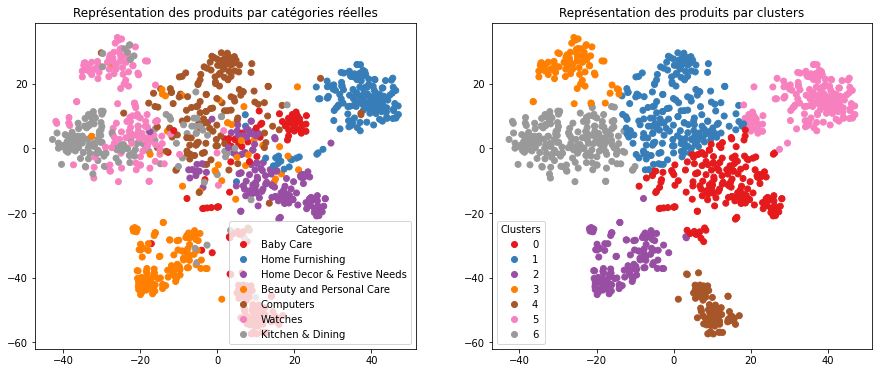

ARI :  0.4874


In [33]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [34]:
# Avec un ARI de 0.4874, on peut conclure que fusionner les features ne nous apporte pas une meilleur prédiction que les features
# Texte seul.